In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from typing import Dict, Tuple, List

In [115]:
EMPTY = -1

In [103]:
def schelling_model(grid: np.ndarray, alpha: int, max_iter: int) -> List[np.ndarray]:
    grids = []
    agent_types = np.unique(grid)
    updated = True
    i = 0
    while updated and i < max_iter:
        if i % 100 == 0:
            print(i)
            grids.append(grid)
            grid = np.copy(grid)
        grid, updated = schelling_ca(grid, agent_types, alpha)
        i += 1
    grids.append(grid)
    return grids

In [49]:
def schelling_ca(grid: np.ndarray,
                 agent_types: np.ndarray,
                 alpha: int) -> Tuple[np.ndarray, bool]:
    neigh_fractions = {a_type: compute_fractions(grid, a_type) for a_type in agent_types}
    preferences = compute_preferences(grid, neigh_fractions, alpha)
    return relocate_agents(np.copy(grid), preferences)

In [97]:
def compute_fractions(grid: np.ndarray, agent_type: int) -> np.ndarray:
    n_rows, n_cols = grid.shape
    fractions = np.empty(grid.shape)
    for i in range(n_rows):
        for j in range(n_cols):
            neigh = neighbourhood(grid, i, j)
            neigh = filter(lambda n: n != EMPTY, neigh)
            n_preffered = sum(map(lambda n: agent_similarity(agent_type, n), neigh))
            fractions[i, j] = n_preffered
    return fractions

In [51]:
def compute_preferences(grid: np.ndarray,
                        fractions: Dict[int, np.ndarray],
                        alpha: int
                       ) -> Dict[Tuple[int, int], List[Tuple[int, int]]]:
    n_rows, n_cols = grid.shape
    preferences = defaultdict(lambda: [])
    all_si = []
    for i in range(n_rows):
        for j in range(n_cols):
            agent_type = grid[i, j]
            if agent_type != EMPTY:
                si = fractions[agent_type][i, j]
                all_si.append(si)
                if si < alpha:
                    empty_neigh = [indices for indices in neigh_indices(grid, i, j) if grid[indices] == EMPTY]
                    if empty_neigh:
                        new_indices = random.choice(empty_neigh)
                        preferences[new_indices].append((i, j))
    return preferences

In [63]:
def relocate_agents(grid: np.ndarray,
                    preferences: Dict[Tuple[int, int], List[Tuple[int, int]]]
                   ) -> Tuple[np.ndarray, bool]:
    relocated = False
    for target, agents in preferences.items():
        if len(agents) == 1:
            grid[target] = grid[agents[0]]
            grid[agents[0]] = EMPTY
            relocated = True
    return grid, relocated

In [53]:
def neighbourhood(grid: np.ndarray, i: int, j: int) -> np.ndarray:
    return np.array([grid[i, j] for i, j in neigh_indices(grid, i, j)])

In [54]:
def neigh_indices(grid: np.ndarray, i: int, j: int) -> List[Tuple[int, int]]:
    n, _ = grid.shape
    candidates = [
        (i-1, j-1),
        (i-1, j),
        (i-1, j+1),
        (i, j-1),
        (i, j+1),
        (i+1, j-1),
        (i+1, j),
        (i+1, j+1),
    ]
    return [(i,j) for (i,j) in candidates if i>=0 and j>=0 and i<n and j<n]

In [118]:
colors = [(1, 1, 1), (1, 0, 0), (0, 0, 1), (1, 0, 1), (0, 1, 0)]
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=5)
def plot_grid(grid: np.ndarray):
    return plt.imshow(grid, cmap=cmap)    

In [135]:
def visualize(grids: List[np.ndarray], filename: str = 'animation.gif'):
    fig = plt.figure(figsize=(10,10))
    im = plot_grid(grids[0])
    ani = FuncAnimation(fig, plot_grid, grids)
    writergif = PillowWriter(fps=1) 
    ani.save(filename, writer=writergif)
    fig.colorbar(im)
    plt.show()

In [128]:
def create_grid(size: int, densities: Dict[int, float]) -> np.ndarray:
    print(f'Total people density: {sum(densities.values())}')
    grid = []
    for field_type, density in densities.items():
        n_fields = int(size * size * density)
        grid += [field_type for _ in range(n_fields)]
    grid += [EMPTY for _ in range(size * size - len(grid))]
    np.random.shuffle(grid)
    return np.array(grid).reshape((size, size))

In [129]:
def agent_similarity(a1: int, a2: int) -> int:
    similarities = ~(a1 ^ a2)
    result = 0
    for _ in range(N_FEATURES):
        result += similarities % 2
        similarities = similarities >> 2
    return result

In [245]:
a = np.array([[1,0,2], [0,0,2], [1,1,2]])
a

array([[1, 0, 2],
       [0, 0, 2],
       [1, 1, 2]])

In [140]:
N_FEATURES = 2 # race, poverty

all_space = 135_000
all_people = 81_334
all_poverty_people = 11_887
white_people = 60_371
white_poverty_people = 8_118

white = (white_people - white_poverty_people) / all_space
white_poverty = white_poverty_people / all_space
minority = (all_people - white_people - all_poverty_people + white_poverty_people) / all_space
minority_poverty = (all_poverty_people - white_poverty_people) / all_space

def experiment(n, alpha):
    initial = create_grid(n, {0: white, 1: white_poverty, 2: minority, 3: minority_poverty})
    grids = schelling_model(initial, alpha=alpha, max_iter=3000)
    visualize(grids, f'simulation_{n}_{N_FEATURES}_{alpha}.gif')

In [141]:
experiment(200, 6)

Total people density: 0.602474074074074
0


KeyboardInterrupt: 

In [ ]:
experiment(200, 7)

In [126]:
grids = schelling_model(initial, alpha=8, max_iter=3000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


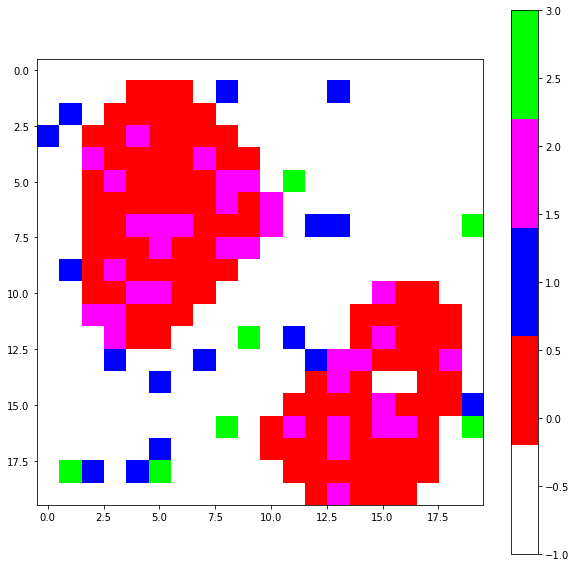

In [127]:
visualize(grids)

<IPython.core.display.Javascript object>


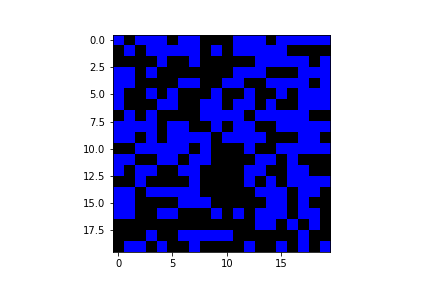

In [301]:
plot_grid(initial)
plt.show()

In [99]:
agent_similarity(1, -1)

1

In [150]:
a = schelling_ca(a, np.array([1,2]))
a

array([[0, 0, 2],
       [1, 1, 2],
       [1, 0, 2]])

In [132]:
a[(2, 1)]

1

In [78]:
relocate_agents(a, None)

([2, 1, 0], [2, 1, 0])

In [18]:
def pad(grid: np.ndarray) -> np.ndarray:
    return np.pad(grid, (1), constant_values=(EMPTY))

In [19]:
def unpad(grid: np.ndarray) -> np.ndarray:
    return grid[1:-1, 1:-1]

In [163]:
a = np.array([[1,0,2], [0,0,2], [1,1,2]])
a

array([[1, 0, 2],
       [0, 0, 2],
       [1, 1, 2]])

In [123]:
compute_fractions(a, 1)

[0 0 0]
[1 2 0 0 2]
[0 0 2]
[1 0 0 1 1]
[1 0 2 0 2 1 1 2]
[0 2 0 1 2]
[0 0 1]
[0 0 2 1 2]
[0 2 1]


array([[0.        , 0.33333333, 0.        ],
       [1.        , 0.5       , 0.33333333],
       [1.        , 0.33333333, 0.5       ]])

In [124]:
compute_fractions(a, 2)

[0 0 0]
[1 2 0 0 2]
[0 0 2]
[1 0 0 1 1]
[1 0 2 0 2 1 1 2]
[0 2 0 1 2]
[0 0 1]
[0 0 2 1 2]
[0 2 1]


array([[0.        , 0.66666667, 1.        ],
       [0.        , 0.5       , 0.66666667],
       [0.        , 0.66666667, 0.5       ]])

In [40]:
a = [1,2,3,4]
np.random.shuffle(a)
a

[3, 4, 1, 2]

In [8]:
schelling(np.ones((2,2), dtype=int))

array([1])